In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import datetime
import os.path
from os import path

import matplotlib.pyplot as plt

# Helper functions for multiple indexes

## Unit conversion

In [2]:
def convert_temp(unit_from, unit_to, temp):

    if(unit_from != unit_to):
        if(unit_to == "K"):
            if(unit_from == "degC"):
                return_temp = temp + 273.15
            elif(unit_from == "degF"):
                return_temp = (temp - 32.0) / 1.8 + 273.15
        elif(unit_to == "degC"):
            if(unit_from == "K"):
                return_temp = temp - 273.15
            elif(unit_from == "degF"):
                return_temp = (temp - 32.0) / 1.8
        elif(unit_to == "degF"):
            if(unit_from == "K"):
                return_temp = (temp - 273.15) * 1.8 + 32.0
            elif(unit_from == "degC"):
                return_temp = temp * 1.8 + 32.0
        else:
            print("The selection of unit", unit_to, "is not recognized. Available options for temperature units are degC, degF, and K")
    else:
            return_temp = temp

    return(return_temp)

def convert_prec(unit_from, unit_to, prec):
    if(unit_from != unit_to):
        if(unit_to == "kg m-2 s-1"):
            if(unit_from == "mm/day"):
                return_pr = prec / 86400.0
            elif(unit_from == "inches/day"):
                return_pr = prec * 24.4 / 86400.0
        elif(unit_to == "mm/day"):
            if(unit_from == "kg m-2 s-1"):
                return_pr = prec * 84600.0
            elif(unit_from == "inches/day"):
                return_pr = prec * 25.4
        elif(unit_to == "inches/day"):
            if(unit_from == "kg m-2 s-1"):
                return_pr = prec * 86400.0 / 25.4
            elif(unit_from == "mm/day"):
                return_pr = prec / 25.4
        elif(unit_to == "inches/hour"):
            if(unit_from == "kg m-2 s-1"):
                return_pr = prec * 3600.0 / 25.4
            elif(unit_from == "mm/day"):
                return_pr = prec / (24. * 25.4)
            elif(unit_from == "inches/day"):
                return_pr = prec / 24.
        else:
            print("the selection of unit", unit_to, "is not recognized. Available options for precipitation units are kg m-2 s-1, mm/day, inches/day, and inches/hour")
    else:
            return_pr = prec
            
    return(return_pr)

def convert_humid(unit_from, unit_to, rh):
    if(unit_from != unit_to):
        if(unit_to == "%"):
            if(unit_from == "1"):
                return_rh = rh * 100.
        elif(unit_to == "1"):
            if(unit_from == "%"):
                return_rh = rh / 100.
        else:
            print("the selection of unit", unit_to, "is not recognized. Available options for humidity units are 1 (unitless) or %")
    else:
        return_rh = rh
    if(unit_to == "1"):
        return_rh = np.clip(return_rh, 0., 1.)
    elif(unit_to == "%"):
        return_rh = np.clip(return_rh, 0., 100.)
        
    return(return_rh)
    
def convert_wind(unit_from, unit_to, wind):
    if(unit_from != unit_to):
        if(unit_to == "m/s" or unit_to == "m s-1"):
            if(unit_from == "mph"):
                return_wind = wind / 2.23694
            elif(unit_from == "kts"):
                return_wind = wind / 1.94386
        elif(unit_to == "mph"):
            if(unit_from == "m/s" or unit_from == "m s-1"):
                return_wind = wind * 2.23694
            elif(unit_from == "kts"):
                return_wind = wind * 1.15078
        elif(unit_to == "kts"):
            if(unit_from == "m/s" or unit_from == "m s-1"):
                return_wind = wind * 1.94386
            elif(unit_from == "mph"):
                return_wind = wind / 1.15078
                
        else:
            print("the selection of unit", unit_to, "is not recognized. Available options for wind units units are m/s, m s-1, kts, and mph")
    else:
        return_wind = wind
    return(return_wind)

## Other functions 

In [3]:
def print_time_error(time_days, acceptable_days):
    time_years = time_days / 365.
    acceptable_years = math.floor(acceptable_days / 365.)
    
    if(time_days < acceptable_days):
        print("Warning: the number of years of data,", str(time_years), "(", str(time_days), "days) is fewer than what is recommended for accuracy.  A minimum of ", str(acceptable_years), "year(s) (",str(math.floor(acceptable_days)), "days) is recommended.")

        
def check_time_length(time_days, acceptable_days, opt):
    if(opt == False):
        print_time_error(time_days, acceptable_days)
    else:
        if(hasattr(opt, "suppressWarning")):
            if(opt.suppressWarning == True):
                print_time_error(time_days, acceptable_days)



# Plot testing function

In [4]:
def test_plot(ref_index, test_index, varname):
    fig, ax = plt.subplots(2, 3, figsize = (20,6))

    for x in range(0,2,1):
        for y in range(0,3,1):
            
            ax[x,y].plot(ref_index.time, ref_index[:, x, y], '--', c = "blue", alpha = .5)
            ax[x,y].plot(test_index.time, test_index[:,x,y], '-', c = "orange", alpha = .5)

def plot_diff(ref_index, test_index, varname):
    fig, ax = plt.subplots(2, 3, figsize = (20,6))

    for x in range(0,2,1):
        for y in range(0,3,1):
            
            ax[x,y].plot(ref_index.time, ref_index[:, x, y] - test_index[:, x, y], '--', c = "violet")
    

# Read in testing files

In [5]:
precfile = 'fire_sample_inputs/prec.gridMET.NAM-22i.20000101-20011231.nc'
tmaxfile = 'fire_sample_inputs/tmax.gridMET.NAM-22i.20000101-20011231.nc'
spdfile = 'fire_sample_inputs/sfcWind.gridMET.NAM-22i.20000101-20011231.nc'
kbdifile = 'fire_sample_inputs/kbdi.gridMET.NAM-22i.20000101-20011231.nc'
hursfile = 'fire_sample_inputs/hurs.gridMET.NAM-22i.20000101-20011231.nc'
rhmaxfile = 'fire_sample_inputs/rhmax.gridMET.NAM-22i.20000101-20011231.nc'
rhminfile = 'fire_sample_inputs/rhmin.gridMET.NAM-22i.20000101-20011231.nc'
tminfile = 'fire_sample_inputs/tmin.gridMET.NAM-22i.20000101-20011231.nc'

prec = xr.open_dataset(precfile)
tmax = xr.open_dataset(tmaxfile)
kbdi_in = xr.open_dataset(kbdifile)

hursnc = nc.Dataset(hursfile)
spdnc = nc.Dataset(spdfile)
rhmaxnc = nc.Dataset(rhmaxfile)
rhminnc = nc.Dataset(rhminfile)

spd=xr.DataArray(data=spdnc['spd'][:],
                dims=["time", "lat", "lon"],
               coords=dict(
                   time=spdnc['time'][:],
                   lat=spdnc['lat'][:],
                   lon=spdnc['lon'][:]
               ),
               attrs=dict(long_name=spdnc['spd'].long_name, units=spdnc['spd'].units)
       )
hurs=xr.DataArray(data=hursnc['hurs'][:],
                dims=["time", "lat", "lon"],
               coords=dict(
                   time=hursnc['time'][:],
                   lat=hursnc['lat'][:],
                   lon=hursnc['lon'][:]
               ),
               attrs=dict(long_name=hursnc['hurs'].long_name, units=hursnc['hurs'].units)
       )
rhmax=xr.DataArray(data=rhmaxnc['rhmax'][:],
                   dims=["time", "lat", "lon"],
                   coords=dict(
                       time=rhmaxnc['time'][:],
                       lat=rhmaxnc['lat'][:],
                       lon=rhmaxnc['lon'][:]
                   ),
                   attrs=dict(long_name=rhmaxnc['rhmax'].long_name, units=rhmaxnc['rhmax'].units)
                  )
rhmin=xr.DataArray(data=rhminnc['rhmin'][:],
                   dims=["time", "lat", "lon"],
                   coords=dict(
                       time=rhminnc['time'][:],
                       lat=rhminnc['lat'][:],
                       lon=rhminnc['lon'][:]
                   ),
                   attrs=dict(long_name=rhminnc['rhmin'].long_name, units=rhminnc['rhmin'].units)
                  )

tmin = xr.open_dataset(tminfile)

# KBDI

## Define function

In [6]:
def calc_kbdi(prec, tmax, calendar, opt):
    """ 
    Calculates Keetch Byram Drought Index. 
        prec is daily precipitation
        tmax is daily maximum temperature
        calendar is the string describing which calendar was used for prec, tmax. 
            Supported calendars: 
                gregorian, standard, 365_day, 366_day, 360_day, no_leap, all_leap
    """
    #Need to add functionality to test if units exist!
    prec_v = convert_prec(prec.units, "inches/day", prec[:])
    tmax_v = convert_temp(tmax.units, "degF", tmax[:])
    
    kbdi_v = prec_v * 0.0
    
    precip_acc = prec_v[0,:,:] * 0.0
    
    Q = kbdi_v[0,:,:] + 100.
    
    total_precip = np.sum(prec_v, axis = 0)
    
    if(calendar == "gregorian" or calendar == "standard"):
        ndaysyear = 365.2425
    elif(calendar == "noleap" or calendar == "365_day"):
        ndaysyear = 365.0
    elif(calendar == "all_leap" or calendar == "366_day"):
        ndaysyear = 366.0
    elif(calendar == "360_day"):
        ndaysyear = 360.0
    else:
        print("calendar not recognized. Proceeding with gregorian/standard calendar.")
        ndaysyear = 365.2425
        
    ndays = len(prec_v[:,0,0])
    nyears = ndays / ndaysyear
    
    check_time_length(ndays, ndaysyear * 30., opt)
    
    annual_pr = total_precip / nyears
    
    for i in range(0,ndays,1):
        precip_d = prec_v[i, :, :]
        maxtemp = tmax_v[i, :, :]
        
        #precip_adj = precip_d * 0.0 # assuming that there was no precipitation the day before calculations started
        precip_acc = np.where(precip_d <= 0.0, 0.0, precip_acc + precip_d)
        precip_adj = np.maximum((precip_acc - 0.2), 0.0) 
        precip_acc = np.clip(precip_acc, 0., 8., out=precip_acc)
        
        #dQ is incremental change in KBDI
        dQ = np.where(maxtemp >= 50.0, (800.0 - Q) * (0.968 * np.exp(0.0486 * maxtemp) - 0.83) / (1. + 10.88 * np.exp(-0.0441 * annual_pr)) * 0.001, 0)
        #dQ is adjusted to 0 when maxtemp < 50 deg F, otherwise is calculated according to KBDI original paper. Adjustment taken from Liu et al.
        
        Q = Q + dQ - (precip_adj * 100) #drought index is reduced 1 point for every .01 inches of adjusted rainfall        
        Q = np.clip(Q, 0, 800)
        
        kbdi_v[i, :, :] = Q

    #Assign metadata and correct structure for return dataset
    kbdi=xr.DataArray(data=kbdi_v,
                    dims=["time", "lat", "lon"],
                   coords=dict(
                       time=prec.time,
                       lat=prec.lat,
                       lon=prec.lon
                   ),
                   attrs=dict(long_name="Keetch Byram Drought Index", units="1")
           )
        
    return(kbdi_v)

## Run test files

In [7]:
#precfile = 'fire_sample_inputs/prec.gridMET.NAM-22i.20000101-20011231.nc'
#tmaxfile = 'fire_sample_inputs/tmax.gridMET.NAM-22i.20000101-20011231.nc'
#prec = xr.open_dataset(precfile)
#tmax = xr.open_dataset(tmaxfile)


In [8]:
#prec.prec
#tmax.tmax

kbdi = calc_kbdi(prec.prec, tmax.tmax, "gregorian", False)

In [9]:
origkbdifile = 'fire_sample_inputs/kbdi.gridMET.NAM-22i.20000101-20011231.ref.nc'
kbdiRef = xr.open_dataset(origkbdifile)

## Test plots

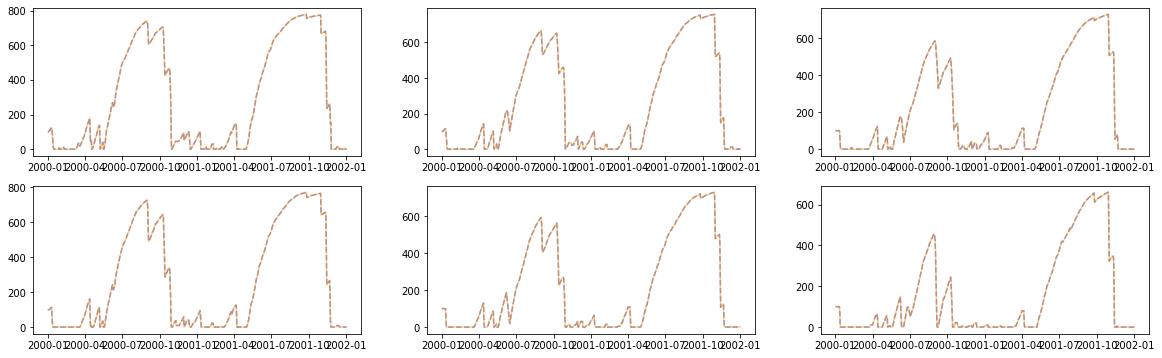

In [10]:
test_plot(kbdiRef.kbdi, kbdi, 'kbdi')

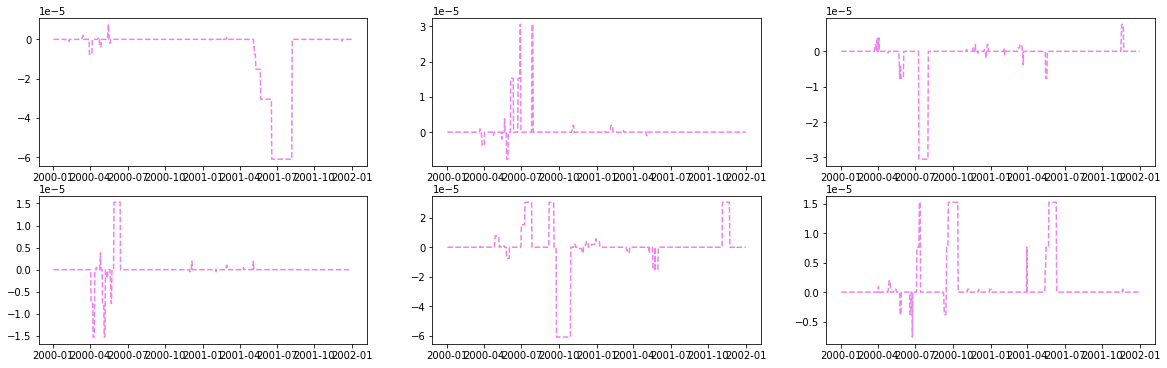

In [11]:
plot_diff(kbdiRef.kbdi, kbdi, 'kbdi')

# mFFWI

## Define function

In [12]:
def calc_emc(T, H):
    emc = 2.22749 + 0.160107 * H - 0.014784 * T
    #print(T)
    #print(H)
    #print("T.sizes=", T.size)
    emc = np.where(H < 10., 0.03229 + .281073 * H - .000578 * T * H, emc)
    emc = np.where(H > 50., 21.0606 + 0.005565 * (H**2.0) - 0.00035 * H * T - 0.483199 * H, emc)

    return(emc)

def calc_mffwi(tmax, rh, spd, kbdi):
    rh = convert_humid(rh.units, "%", rh)
    tmax = convert_temp(tmax.units, "degF", tmax)
    spd = convert_wind(spd.units, "mph", spd)
    
    rh_ = rh.data
    tmax_ = tmax.data
    spd_ = spd.data
    kbdi_ = kbdi.data
    
    c1 = 1.0
    c2 = 1.5
    c3 = -0.5
    
    em0 = 0.72
    em = 0.000002
    bf = 1. / 0.3002

    emc = calc_emc(tmax_, rh_) #equilibrium moisture content

    eta = 1 - 2 * (emc / 30) + c2 * ((emc / 30) ** 2) + c3 * ((emc / 30) ** 3)
    FFWI = bf * eta * (1 + (spd_**2.))**0.5
    FAF = em0 + (em * (kbdi_**2.))

    mffwi_v = FAF * FFWI

    mffwi=xr.DataArray(data=mffwi_v,
                dims=["time", "lat", "lon"],
               coords=dict(
                   time=tmax.time,
                   lat=tmax.lat,
                   lon=tmax.lon
               ),
               attrs=dict(long_name="modified Fosberg Fire Weather Index", units="1")
       )

    
    return(mffwi)


## Run test files

In [13]:
mffwi = calc_mffwi(tmax.tmax, hurs, spd, kbdi_in.kbdi)

In [14]:
origmffwifile = 'fire_sample_inputs/mffwi.gridMET.NAM-22i.20000101-20011231.ref.nc'
mffwiRef = xr.open_dataset(origmffwifile)

## Test plots

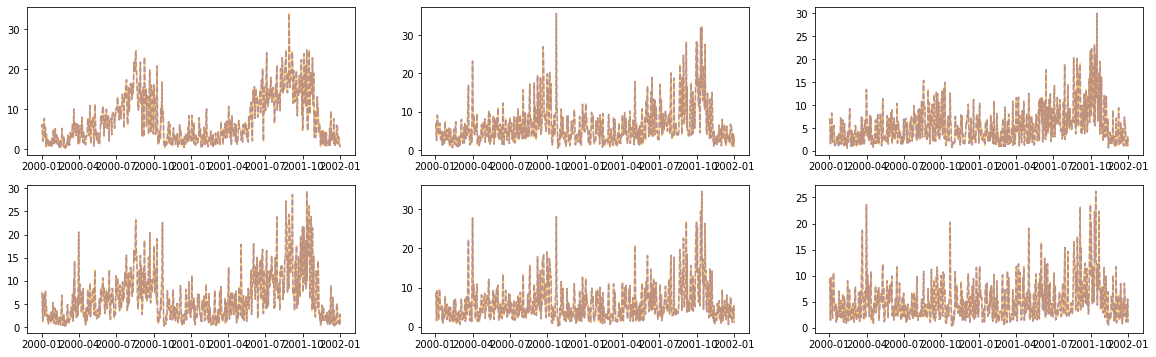

In [15]:
test_plot(mffwiRef.mffwi, mffwi, 'mffwi')

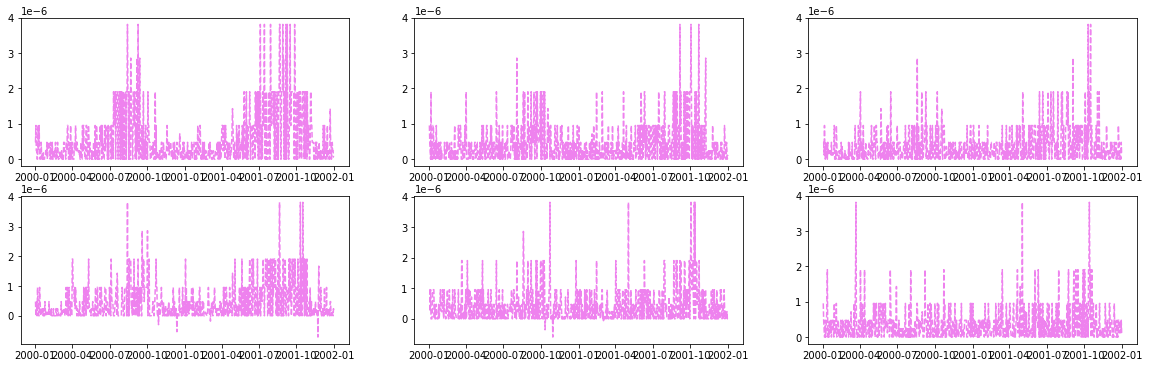

In [16]:
plot_diff(mffwiRef.mffwi, mffwi, 'mffwi')

# CFWI
## Define function

In [17]:
def calc_julian_day(time, index, prev_day):
    #time should be the whole time series
    timestr = str(time.data[index])
    #print(timestr[0:10])
    cal = datetime.datetime.strptime(timestr[0:10], "%Y-%m-%d")

    month_day = cal.strftime("%m %d")

    if(index == 0):   #This is for finding the first day, without making an assumption that the file starts on Jan 1
        i = 0
        while(month_day != "01 01"):
            timestr = str(time[i])
            cal = datetime.datetime.strptime(timestr[0:10], "%Y-%m-%d")

            month_day = cal.strftime("%m %d")

            i = i + 1
        if(i == 0):
            day_of_year = 1
        else:
            day_of_year = 365 - i + 1
    else:
        if(month_day == "01 01"):
            day_of_year = 1
        else:
            day_of_year = prev_day + 1

    return(day_of_year)
    
def calc_daylight(j_date, lat, lonlen):
    phi = lat * 0.01745

    # this next block replaces conform_dims in ncl
    phi1 = np.ones((j_date.size, lat.size))
    for i in range(0,j_date.size, 1):
        phi1[i][:] = phi
    
    decl = .41008 * np.sin((j_date-82.) * .01745)

    #again, conform_dims replacement below
    decl1 = np.ones((j_date.size, lat.size))

    for i in range(0,lat.size, 1):
        decl1[:,i] = decl
        
    daylit = 24 * (1-np.arccos(np.tan(phi1) * np.tan(decl1)) / 3.14159)
    
    daylit1 = np.ones((j_date.size, lat.size, lonlen))
    for i in range(0, lonlen, 1):
        daylit1[:,:,i] = daylit
        
    return(daylit1)

def calc_ffmc(Fo, H, T, W, ro):
    """    
    Fo is the previous day's FFMC
    H is average relative humidity
    T is average temperature in Celsius
    W is wind speed in mph
    ro is daily rainfall, unadjusted
    """
    
    mo = 147.2 * (101. - Fo) / (59.5 + Fo)
    rf = np.where(ro > .5, ro - .5, 0.)
    #following line tests if there was precipitation, then modify mo to account for precip. There are also 2 options for what modification needs to be made, hence the nested where statements
   #print("rf =",rf)
    mo = np.where(rf > 0., 
                  np.where(mo > 150., 
                           mo + 42.5 * rf * np.exp(-100. / (251. - mo)) * (1 - np.exp(-6.93 / rf)) + .0015 * ((mo - 150.)**2) * np.sqrt(rf), 
                           mo + 42.5 * rf * np.exp(-100. / (251. - mo)) * (1 - np.exp(-6.93 / rf))
                          ), 
                  mo
                 )
    #print("mo =",mo)
    Ed = .942 * H**0.679 + 11 * np.exp((H - 100.)/10.) + 0.18 * (21.1 - T) * (1 - np.exp(-.115 * H))
    Ew = .618 * H**.753 + 10 * np.exp((H-100.)/10.) + 0.18 * (21.1 - T) * (1 - np.exp(-.115 * H))

    #print("W =", W)
    ko1 = np.where(mo > Ed, 0.424 * (1 - (H / 100)**1.7)+ 0.0694 * np.sqrt(W) * (1 - (H / 100)**8.), 0.424 * (1 - ((100 - H) / 100)**1.7) + 0.0694 * np.sqrt(W) * (1 - ((100 - H) / 100)**8))
    kdw = ko1 * 0.581 * np.exp(0.0365 * T)

    m = np.where(mo > Ed, Ed + (mo - Ed) * 10**(-kdw), mo)
    m = np.where(mo < Ew, Ew - (Ew - mo) * 10**(-kdw), m)
    
    m = np.clip(m, 0.0, 250.0)

    return(m)

def calc_dmc(Po, T, ro, H, Le):
    """
    Po is the previous day's DMC
    Le is length of day/ amount of sunlight
    """
    T_dmc = np.clip(T, -1.1, None)
    re = np.where(ro > 1.5, .92 * ro - 1.27, 0)    #adjust precip
    Mo = 20. + np.exp(5.6348 - (Po / 43.43))
    b = 14. - 1.3 * np.log(Po)
    b = np.where(Po > 65., 6.2 * np.log(Po) - 17.2, b)
    b = np.where(Po < 33., 100. / (.5 + .3 * Po) , b)
    Mr = np.where(re > 0, Mo + (1000. * re / (48.77 + b * re)), 0) #only if there's precip
    Po = np.where(re > 0, 244.72 - 43.43 * np.log(Mr - 20.), Po)       #only if there's precip
    Po = np.clip(Po, 0.0, None)
    K = 1.894 * (T_dmc + 1.1) * (100 - H) * Le * (10**(-6))
    
    P = np.clip(Po + 100 * K, 0.0, None)

    return(P)

def calc_dc(ro, T, Do, Lf):
    T_dc = np.clip(T, -2.8, None)

    rd = np.where(ro > 2.8, 0.83 * ro - 1.27, -1)   #adjust precip

    Qo = 800 * np.exp(-Do / 400.)
    #Qr = where(rd .gt. 0., Qo + (3.937 * rd), -1)           ;only if precip
    Qr = Qo + (3.937 * rd)
    Dr = np.where(rd > 0., 400. * np.log(800. / Qr), Do)       #only if precip
    Dr = np.clip(Dr, 0.0, None)

    V = (.36 * (T_dc + 2.8)) + Lf
    V = np.clip(V, 0.0, None)
    Drou = np.clip(Dr + .5 * V, 0.0, None)

    return(Drou)

def calc_isi(W, m):
    fw = np.exp(.05039 * W)
    ff = 91.9 * np.exp(-0.1386 * m) * (1 + (m**5.31 / (4.93 * 10**7)))
    r = np.clip(0.208 * fw * ff, 0.0, None)

    return(r)

def calc_bui(P, D):
    D1 = np.where((P == 0.) & (D == 0.), math.nan, D)
    P1 = np.where((P == 0.) & (D == 0.), math.nan, P)

    dfour = .4 * D1

    U = np.where(P1 > dfour, P1 - (1. - .8 * D1 / (P1 + dfour)) * (.92 + (0.0114 * P1)**1.7), 0.8 * P1 * D1 / (P1 + dfour))
    U = np.where(np.isnan(D1), 0., U)
         
    U = np.clip(U, 0.0, None)    #not a check explicitly stated in the paper, but prevents calculations that result in non-real numbers
    

    return(U) 


In [18]:
def calc_cfwi(tmax, prec, hurs, spd, time, lat, lon, opt):

    
    #Unit calculations done manually at the moment, but cfunits should be used in the future.
    hurs = convert_humid(hurs.units, "%", hurs)
    prec = convert_prec(prec.units, "mm/day", prec)
    tmax = convert_temp(tmax.units, "degC", tmax)
    spd = convert_wind(spd.units, "m/s", spd)
    
    hurs_ = hurs.data
    prec_ = prec.data
    tmax_ = tmax.data
    spd_ = spd.data
    
    ffmc = prec[0, :, :] / prec[0,:,:]
    dmc = ffmc
    dc = ffmc
    m = ffmc
    
    ffmc = ffmc * 85.0
    dmc = dmc * 6.0
    dc = dc * 15.0
    m = m * 0.0
    
    Lf = [-1.6, -1.6, -1.6, .9, 3.8, 5.8, 5.8, 6.4, 5.0, 2.4, .4, -1.6, -1.6]
    
    ndays = len(time)
    check_time_length(ndays, 365, opt)
    
    cfwi_v = prec_ * 0.0
    #print(cfwi_v)
    day_of_year = -1
    
    #print(time.data)
    for i in range(0,ndays, 1):
        
        #print(time[i])
        day_of_year = calc_julian_day(time, i, day_of_year)
        #print(month_day, day_of_year)
        Le = calc_daylight(np.array([day_of_year]), lat.data, lon.data.size)
        
        m = calc_ffmc(ffmc, hurs_[i, :, :], tmax_[i, :, :], spd_[i,:,:], prec_[i,:,:])
        ffmc = 59.5 * (250. - m) / (147.2 + m)
        dmc = calc_dmc(dmc, tmax_[i,:,:], prec_[i,:,:], hurs_[i,:,:], Le)
        
        timestr = str(time.data[i])
        cal = datetime.datetime.strptime(timestr[0:10], "%Y-%m-%d")
        month_int = int(cal.strftime("%m"))

        dc = calc_dc(prec_[i,:,:], tmax_[i,:,:], dc, Lf[month_int - 1])
        
        isi = calc_isi(spd_[i,:,:], m)
        bui = calc_bui(dmc, dc)
        
        fd = np.where(bui > 80., 1000. / (25. + 108.64 * np.exp(-0.023 * bui)), 0.626 * bui**0.809 + 2)
        B = 0.1 * isi * fd
        #print(i)
        #print(B)
        #print(cfwi_v[i,:,:])
        cfwi_v[i, :, :] = np.where(B > 1., np.exp(2.72 * (.434 * np.log(B))**.647), B)
        
        cfwi_v[i, :, :] = np.clip(cfwi_v[i,:,:], 0.0, None)
        
    cfwi = xr.DataArray(data=cfwi_v,
                        dims=["time", "lat", "lon"],
                        coords=dict(
                            time=prec.time,
                            lat=prec.lat,
                            lon=prec.lon
                        ),
                        attrs=dict(long_name="Canadian Fire Weather Index", units="1")
                       )

    
    return(cfwi)   



## Run test files

In [19]:
cfwi = calc_cfwi(tmax.tmax, prec.prec, hurs, spd, tmax.time, tmax.lat, tmax.lon, True)
cfwi

/glade/u/apps/ch/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in log
/glade/u/apps/ch/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in power
/glade/u/apps/ch/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/glade/u/apps/ch/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/glade/u/apps/ch/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in log
/glade/u/apps/ch/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: in

<xarray.DataArray (time: 731, lat: 2, lon: 3)>
array([[[2.7488223e-01, 2.6609635e-01, 5.2980655e-01],
        [3.7188986e-01, 3.7365210e-01, 7.6106101e-01]],

       [[3.5354060e-01, 2.7040610e-01, 4.1288528e-01],
        [4.5954475e-01, 4.2092553e-01, 5.3772151e-01]],

       [[5.2471602e-01, 3.9098576e-01, 6.1036885e-01],
        [5.7940716e-01, 5.1943779e-01, 6.1091256e-01]],

       ...,

       [[8.4256442e-08, 1.0371838e-06, 3.4498185e-06],
        [9.5927021e-08, 6.8263676e-06, 4.8058287e-06]],

       [[5.0980714e-07, 2.1736882e-05, 4.2231131e-05],
        [1.8116002e-06, 3.1224365e-05, 3.3617813e-05]],

       [[6.5719919e-06, 1.4580706e-05, 2.4106066e-05],
        [2.1934006e-06, 8.9439473e-06, 4.6569280e-06]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T19:00:00 ... 2001-12-31T19:00:00
  * lat      (lat) float64 37.88 38.12
  * lon      (lon) float64 -120.1 -119.9 -119.6
Attributes:
    long_name:  Canadian Fire Weather Index
    units:      1

In [20]:
origcfwifile = 'fire_sample_inputs/cfwi.gridMET.NAM-22i.20000101-20011231.ref.nc'
cfwiRef = xr.open_dataset(origcfwifile)

## Test plots

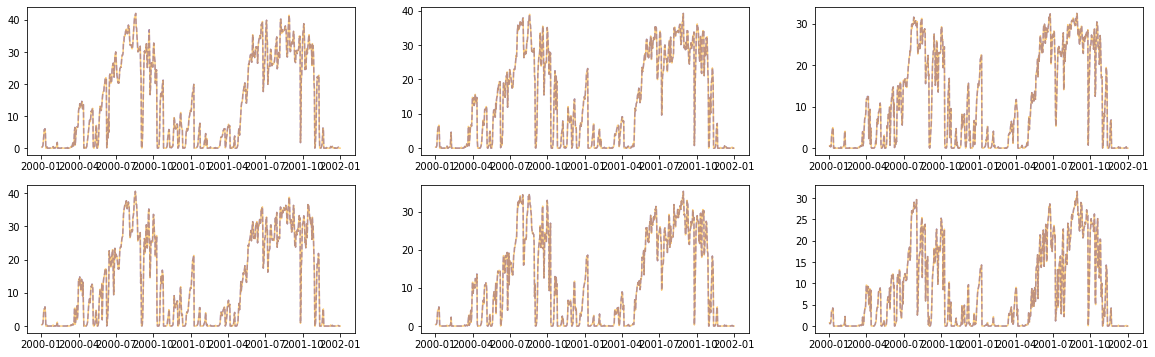

In [21]:
test_plot(cfwiRef.cfwi, cfwi, 'cfwi')

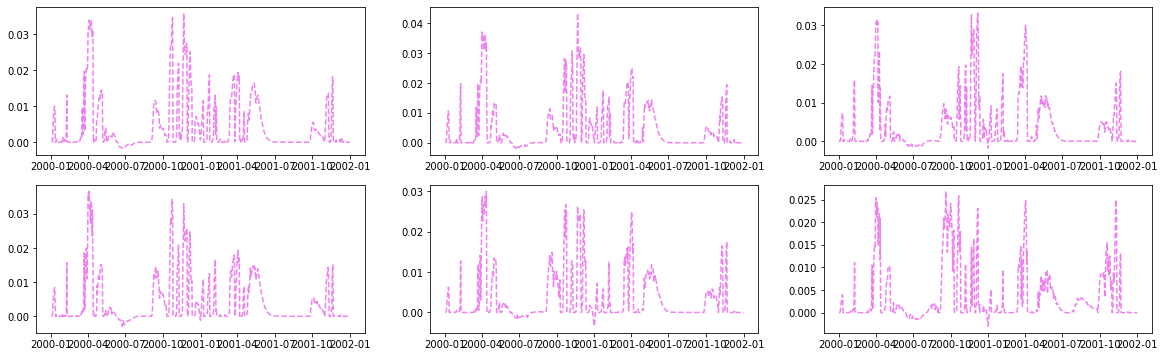

In [22]:
plot_diff(cfwiRef.cfwi, cfwi, 'cfwi')

## Thoughts on differences in CFWI

I think this went shockingly well. The python version has a different implementation of daylight hours calculations. The calc_cfwi function in NCL used the built-in function of daylight_fao56, which I have not looked at the actual code for, and the python version is a manual translation of the calc_daylight function I later used in ERC and Burning Index, originally laid out in John Abatzoglou's ERC code. If needed, I could do a more in depth analysis of where the variation comes from, since my guess is that the place where calculation differs, daylight hours, is just a guess.

# FM100

## Define function

In [88]:
def extract_lat_lon(var, sublat, sublon, reflat, reflon):
    latlength = len(sublat)
    lonlength = len(sublon)
    
    # in case of mismatching units on longitude ...
    reflon1 = np.where(reflon < 0., reflon + 360., reflon)
    sublon1 = np.where(sublon < 0., sublon + 360., sublon)
    
    print("sublat", sublat)
    print("sublon1", sublon1)
    #test if reference file lat and lon match the subset lat and lon
    
    if((latlength == len(reflat)) and (lonlength == len(reflon))):
        match_lat = np.where(sublat == reflat, True, False)
        match_lon = np.where(sublon == reflon, True, False)
        match_lon_360 = where( sublon1 == reflon1, True, False) #this is in case longitude units differ between the reference file and subset file, but the ranges still match
        
        if(np.all(match_lat) and (np.all(match_lon) or np.all(match_lon_360))):
            match_flag = True
        else:
            match_flag = False
        
    else:
        match_flag = False
    
    if(match_flag):
        subset_var = var
        
    else:
        #check if requested lat, lon are within range of file
        if((min(sublat) < min(reflat)) or (max(sublat) > max(reflat))):
            print("The range of latitude does not match available reference files. The latitude range in the inputted reference file is", min(reflat), "to", max(reflat), ". The latitude range in the variable files is", min(sublat), "to", max(sublat))
        if((min(sublon1) < min(reflon1)) or (max(sublon1) > max(reflon1))):
            print("The range of longitude does not match available reference files. The longitude range in the inputted reference file is", min(reflon), "to", max(reflon), ". The latitude range in the variable files is", min(sublon), "to", max(sublon))
        
        lat_index = sublat / sublat * (-1000)
        lat_index = lat_index.astype("int")
        lon_index = sublon / sublon * (-1000)
        lon_index = lon_index.astype("int")
        for i in range(0,latlength,1):
            ind = np.where(reflat == sublat[i])
            lat_index[i] = ind[0][0]
            
            #print("sublat[i]", sublat[i])
            #print("type(ind[0][0])", type(ind[0][0]))
            
            #print("type(lat_index[i])", type(lat_index[i]))
            #print("reflat[lat_index[i]]", reflat[lat_index[i]])
            
        
        for i in range(0,lonlength,1):
            ind = np.where(reflon1 == sublon1[i])
            lon_index[i] = ind[0][0]
            print("sublon1[i]", sublon1[i])
            print("type(ind[0][0])", type(ind[0][0]))
            
            print("type(lon_index[i])", lon_index[i])
            print("reflon[lon_index[i]]", reflon1[lon_index[i]])

            
            
        subset_var = var[lat_index, lon_index]
        
    return(subset_var)


def pjolly(grid, lat, lon):
    if(grid == "NAM-22i"):
        z3file = "fire_sample_inputs/pdur_jolly_22i.nc"
        r_z3 = xr.open_dataset(z3file)
        b = extract_lat_lon(r_z3.Z3, lat, lon, r_z3.lat, r_z3.lon)
    elif(grid == "NAM-44i"):
        z3file = "fire_sample_inputs/pdur_jolly_44i.nc"
        r_z3 = xr.open_dataset(z3file)
        b = extract_lat_lon(r_z3.Z3, lat, lon, r_z3.lat, r_z3.lon)
    else:
        if(path.exists(grid)):
            r_z3 = grid
            b = extract_lat_lon(r_z3.Z3, lat, lon, r_z3.lat, r_z3.lon)
        else:
            print("No file matching that grid is currently available. If a custom file was input, it was not found")
    
def calc_pduration(grid, ppt, lat, lon):
    z3 = pjolly(grid, lat.data, lon.data)
    
    timelen = ppt[:, 0, 0].size
    z3_con = np.ones((timelen, lat.size, lon.size))
    for i in range(0,timelen, 1):
        z3_con[i, :, :] = z3
        
    pdur = 24. * (1. - np.exp(-z3_con * ppt))
    pdur = pdur.round()
    pdur = np.clip(pdur, 0., 8.)
    
    return(pdur)


def calc_fm100(tmax, tmin, prec, rhmax, rhmin, time, lat, lon, grid, opt):
    prec = convert_prec(prec.units, "mm/day", prec)
    tmax = convert_temp(tmax.units, "degF", tmax)
    tmin = convert_temp(tmin.units, "degF", tmin)
    rhmax = convert_humid(rhmax.units, "%", rhmax)
    rhmin = convert_humid(rhmin.units, "%", rhmin)
    
    prec_ = prec.data
    tmax_ = tmax.data
    tmin_ = tmin.data
    rhmax_ = rhmax.data
    rhmin_ = rhmin.data
    
    climcl = 3.
    fm100_v = prec_ * 0.0
    
    yfm = tmax_[0,:,:] / tmax_[0,:,:] * 10.0
    emcmax = calc_emc(tmin_, rhmax_)
    emcmin = calc_emc(tmax_, rhmin_)
    
    latlen = len(lat)
    lonlen = len(lon)
    pptdur = calc_pduration(grid, prec, lat, lon)
    
    fr100 = 1.0 - (0.87 * np.exp(-0.24))
    
    emcbar = emcmin[0, :, :]
    
    ndays = len(time)
    check_time_length(ndays, 365, opt)
    day_year = -1
    
    for i in range(0,ndays, 1):
        day_year = calc_julian_day(time, i, day_year)
        daylit = calc_daylight(np.array(day_year), lat, lonlen)
        #emcbar is average equilibrium moisture content
        emcbar = (daylit * emcmin[i,:,:] + (24.0 - daylit) * emcmax[i, :, :]) / 24.
        
        bndryh = ((24. - pptdur[i, :, :]) * emcbar + pptdur[i, :, :] * (0.5 * pptdur[i, :, :] + 41.0)) / 24.
        fm100_v[i, :, :] = (bndryh - yfm) * fr100 + yfm
        
        yfm = fm100_v[i, :, :]
        
    fm100 = xr.DataArray(data=fm100_v,
                        dims=["time", "lat", "lon"],
                        coords=dict(
                            time=prec.time,
                            lat=prec.lat,
                            lon=prec.lon
                        ),
                        attrs=dict(long_name="Percent Moisture COntent for 100-hr timelag", units="%")
                       )
    return(fm100)

In [89]:
fm100 = calc_fm100(tmax.tmax, tmin.tmin, prec.prec, rhmax, rhmin, tmax.time, tmax.lat, tmax.lon, "NAM-22i", True)

sublat [37.875 38.125]
sublon1 [239.875 240.125 240.375]
[188.125 188.375 188.625 188.875 189.125 189.375 189.625 189.875 190.125
 190.375 190.625 190.875 191.125 191.375 191.625 191.875 192.125 192.375
 192.625 192.875 193.125 193.375 193.625 193.875 194.125 194.375 194.625
 194.875 195.125 195.375 195.625 195.875 196.125 196.375 196.625 196.875
 197.125 197.375 197.625 197.875 198.125 198.375 198.625 198.875 199.125
 199.375 199.625 199.875 200.125 200.375 200.625 200.875 201.125 201.375
 201.625 201.875 202.125 202.375 202.625 202.875 203.125 203.375 203.625
 203.875 204.125 204.375 204.625 204.875 205.125 205.375 205.625 205.875
 206.125 206.375 206.625 206.875 207.125 207.375 207.625 207.875 208.125
 208.375 208.625 208.875 209.125 209.375 209.625 209.875 210.125 210.375
 210.625 210.875 211.125 211.375 211.625 211.875 212.125 212.375 212.625
 212.875 213.125 213.375 213.625 213.875 214.125 214.375 214.625 214.875
 215.125 215.375 215.625 215.875 216.125 216.375 216.625 216.875 21

ValueError: dimensions ('lat', 'lon') must have the same length as the number of data dimensions, ndim=3

In [73]:
round(220.51)

221

In [46]:
a = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
b = np.array([False, True, True, True, False, False, False, False, True, True])
a[b]

array([ 2,  3,  4,  9, 10])

In [50]:
ind = np.where(a == 4)
type(ind[0][0])

numpy.int64